## Machine Learning Mastery Assignment

### Task 1

Task 1: Data Preparation (5 Marks)
- Load a dataset of your choice.
- Perform necessary data preprocessing steps such as handling missing values, encoding categorical variables, and scaling numerical features.


In [1]:
### I will look into image segmentation of hyperspectral satellite images, I have downloaded them previously with python <br>
### library ee (to access google earth engine). I saved them into multiband GeoTIFs. Here, I load the GeoTIFs again and <br>
### load the according segmentation masks again. The segmentation masks are a land-mask I prepared in ee as well as a seagrass <br>
### mask I obtained from governmental sources. I will check the quality of the bands and calculate some band indices. <br>

### first load necessary libraries

import numpy as np
from shapely.geometry import shape
import geopandas as gpd
from rasterio.mask import mask
from shapely.geometry import mapping
from rasterio.features import geometry_mask
from rasterio.plot import show
import holoviews as hv
import hvplot.xarray
import xarray as xr
import hvplot.pandas
from shapely.geometry import box
from shapely.ops import unary_union
import os
from rasterio.enums import Resampling
import contextily
from rasterio.mask import mask
import subprocess
import rasterio as rio
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona

In [2]:
### load segmentation mask for seagrass from governmental source

# Set driver support for KML files
fiona.drvsupport.supported_drivers['KML'] = 'rw'

# Specify the path to the KML file
kml_file_1 = './GeoTIFsForSVM/Muntanyes_d_Arta.kml'

# Read the KML file into a GeoDataFrame
gdf_Mallorca_1 = gpd.read_file(kml_file_1, driver='KML')

In [3]:
### convert segmentation mask from xyz position to xy position

from shapely.geometry import Polygon

# Convert geometries to 2D (remove Z coordinate)
gdf_Mallorca_1.geometry = gdf_Mallorca_1.geometry.apply(lambda geom: Polygon([(point[0], point[1]) for point in geom.exterior.coords]))

# Check the geometries again
gdf_Mallorca_1.head(3)

,Name,Description,geometry
0,3-Alternancia CRI-Posidonia,,"POLYGON ((3.36352 39.77760, 3.36337 39.77753, ..."
1,3-Alternancia CRI-Posidonia,,"POLYGON ((3.37013 39.77552, 3.36980 39.77579, ..."
2,3-Alternancia CRI-Posidonia,,"POLYGON ((3.37171 39.77374, 3.37194 39.77415, ..."


In [4]:
### check if some polygons are overlying

# Assuming combined_gdf is your GeoDataFrame
non_overlapping_geometry_M1 = gdf_Mallorca_1.unary_union

# Convert the MultiPolygon to a GeoDataFrame with one row per Polygon
final_gdf_Mallorca1 = gpd.GeoDataFrame(geometry=[geom for geom in non_overlapping_geometry_M1.geoms])
final_gdf_Mallorca1 = final_gdf_Mallorca1.set_crs(gdf_Mallorca_1.crs)

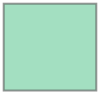

In [5]:
### get coordinates for image region (previously prepared in ee)

# Load shape file
shape_path = './GeoTIFsForSVM/AOI4_shapefile.shp'
gdf_sh = gpd.read_file(shape_path)

# Extract the polygon from the GeoDataFrame
aoi_polygon = gdf_sh['geometry'].iloc[0]
aoi_polygon

In [6]:
### read in land mask prepared in ee

# Specify the path to the shapefile
shapefile_path = "./GeoTIFsForSVM/AOI4d_watermask_geojson.geojson"


# Read the shapefile into a GeoDataFrame
gdf_land_mask = gpd.read_file(shapefile_path)
gdf_land_mask

,id,count,label,geometry
0,+12302+147704,1,0,"POLYGON ((3.31532 39.80543, 3.31559 39.80543, ..."
1,+12323+147672,1,0,"POLYGON ((3.32098 39.79680, 3.32125 39.79680, ..."
2,+12325+147675,1,0,"POLYGON ((3.32152 39.79761, 3.32179 39.79761, ..."
3,+12327+147677,1,0,"POLYGON ((3.32206 39.79815, 3.32233 39.79815, ..."
4,+12330+147693,1,0,"POLYGON ((3.32287 39.80246, 3.32314 39.80246, ..."
...,...,...,...,...
88,+12776+147154,191,1,"POLYGON ((3.44279 39.65748, 3.44279 39.65721, ..."
89,+12781+147622,1,0,"POLYGON ((3.44441 39.78333, 3.44468 39.78333, ..."
90,+12835+147489,1,0,"POLYGON ((3.45896 39.74749, 3.45923 39.74749, ..."
91,+12896+147344,2,0,"POLYGON ((3.47513 39.70841, 3.47567 39.70841, ..."


In [7]:
### chose the largest polygon from self-prepared land mask as actual land mask

# Calculate the area of each polygon
gdf_land_mask['area'] = gdf_land_mask.geometry.area

# Sort the DataFrame by area in descending order
gdf_sorted = gdf_land_mask.sort_values(by='area', ascending=False)

# Keep only the largest polygon (first row)
largest_polygon = gdf_sorted.iloc[0]

# Create a new GeoDataFrame with only the largest polygon
gdf_largest = gpd.GeoDataFrame(geometry=[largest_polygon.geometry])

# Set the CRS if needed
gdf_largest.crs = gdf_land_mask.crs

C:\Users\DPaulssen\AppData\Local\Temp\ipykernel_4348\931836379.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_land_mask['area'] = gdf_land_mask.geometry.area


#### read in GeoTIFs containg multispectral band information (satellite image was stored in 3 files)

In [8]:
# Replace 'your_multiband_geotiff.tif' with the actual file path
file_path = './GeoTIFsForSVM/AOI4c_1_B1_B2_B3_B4_med_Jan_GeoTIFF.tif'

# Open the GeoTIFF file with rasterio
with rio.open(file_path) as src:
    # Read the geospatial metadata
    geotransform = src.transform
    projection = src.crs
    # Read all bands as a numpy array
    bands_data = []
    for i in range(1, src.count + 1):
        band_data = src.read(i)
        bands_data.append(band_data)
    
    # Stack bands into one numpy array
    stacked_data = np.stack(bands_data, axis=-1)
    # Generate variables later needed for creating masks
    _, cropped_transform1 = mask(src, [mapping(aoi_polygon)], crop=False)
    blue_height1, blue_width1 = src.shape    

In [9]:
# Replace 'your_multiband_geotiff.tif' with the actual file path
file_path2 = './GeoTIFsForSVM/AOI4c_2_B5_B8_B8A_med_Jan_GeoTIFF.tif'

# Open the GeoTIFF file with rasterio
with rio.open(file_path2) as src2:
    # Read the geospatial metadata
    geotransform2 = src2.transform
    projection2 = src2.crs
    
    # Read all bands as a numpy array
    bands_data2 = []
    for i in range(1, src2.count + 1):
        band_data2 = src2.read(i)
        bands_data2.append(band_data2)
    
    # Stack bands into one numpy array
    stacked_data2 = np.stack(bands_data2, axis=-1)
    # Generate variables later needed for creating masks
    _, cropped_transform2 = mask(src2, [mapping(aoi_polygon)], crop=False)
    blue_height2, blue_width2 = src2.shape  

In [10]:
# Replace 'your_multiband_geotiff.tif' with the actual file path
file_path3 = './GeoTIFsForSVM/AOI4c_3_B6_B7_B9_B11_B12_med_Jan_GeoTIFF.tif'

# Open the GeoTIFF file with rasterio
with rio.open(file_path3) as src3:
    # Read the geospatial metadata
    geotransform3 = src3.transform
    projection3 = src3.crs
    
    # Read all bands as a numpy array
    bands_data3 = []
    for i in range(1, src3.count + 1):
        band_data3 = src3.read(i)
        bands_data3.append(band_data3)
    
    # Stack bands into one numpy array
    stacked_data3 = np.stack(bands_data3, axis=-1)

In [12]:
### control if images have same shape

print(stacked_data.shape, stacked_data2.shape, stacked_data3.shape)

(590, 629, 4) (590, 629, 3) (590, 629, 5)


In [13]:
### check for nan

print(np.sum(np.isnan(stacked_data)), np.sum(np.isnan(stacked_data2)), np.sum(np.isnan(stacked_data3)))

0 0 0


In [14]:
### check for 0 values -> important for division later

print(np.count_nonzero(stacked_data == 0), np.count_nonzero(stacked_data2 == 0), np.count_nonzero(stacked_data3 == 0))

866600 649958 1083367


#### create land, seagrass and water masks

In [15]:
### seagrass mask

final_gdf_Mallorca1 = final_gdf_Mallorca1.to_crs(projection) ## add needed final gdf here
#blue_height, blue_width = stacked_data[1].shape
#_, cropped_transform = mask(stacked_data[1], [mapping(aoi_polygon)], crop=False)
final_mask_Posidonia = geometry_mask(final_gdf_Mallorca1.geometry, out_shape=(blue_height1, blue_width1), transform=cropped_transform1, invert=True)

In [16]:
final_mask_Posidonia.shape

(590, 629)

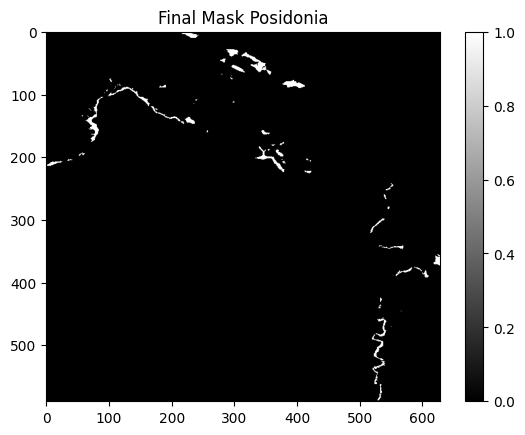

In [17]:
import matplotlib.pyplot as plt

# Plot the binary mask
plt.imshow(final_mask_Posidonia, cmap='gray')
plt.title('Final Mask Posidonia')
plt.colorbar()
plt.show()

In [18]:
### seagrass mask

gdf_largest = gdf_largest.to_crs(projection) ## add needed final gdf here
#blue_height, blue_width = stacked_data[1].shape
#_, cropped_transform = mask(stacked_data[1], [mapping(aoi_polygon)], crop=False)
final_mask_Land = geometry_mask(gdf_largest.geometry, out_shape=(blue_height2, blue_width2), transform=cropped_transform2, invert=True)

In [19]:
final_mask_Land.shape

(590, 629)

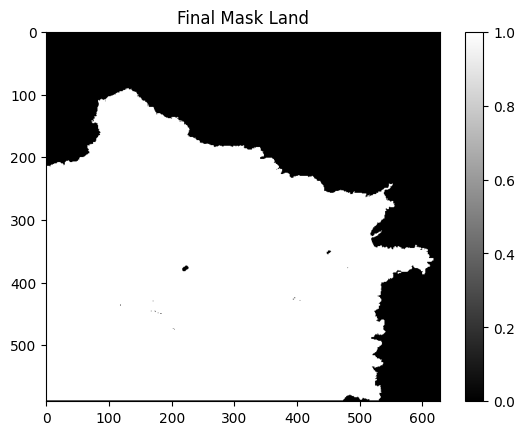

In [20]:
import matplotlib.pyplot as plt
#final_mask_Land = ~final_mask_Land # only use if needed

# Plot the binary mask
plt.imshow(final_mask_Land, cmap='gray')
plt.title('Final Mask Land')
plt.colorbar()
plt.show()

In [21]:
final_mask_water = ~(final_mask_Posidonia | final_mask_Land)

In [22]:
final_mask_water.shape

(590, 629)

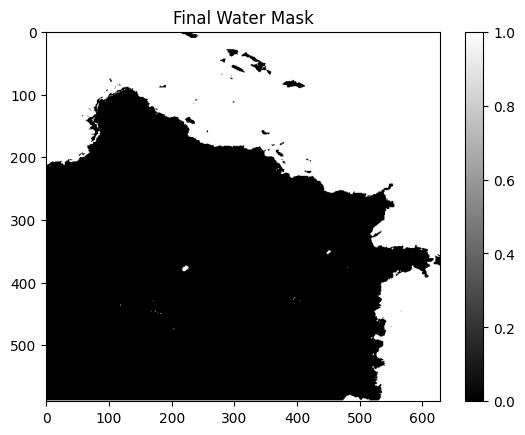

In [23]:
import matplotlib.pyplot as plt

# Plot the binary mask
plt.imshow(final_mask_water, cmap='gray')
plt.title('Final Water Mask')
plt.colorbar()
plt.show()

#### split stacked numpy arrays into single bands

In [24]:
coastal_cropped = stacked_data[:,:,0]
blue_cropped = stacked_data[:,:,1]
green_cropped = stacked_data[:,:,2]
red_cropped = stacked_data[:,:,3]
nir_cropped = stacked_data2[:,:,1]
nir08_cropped = stacked_data2[:,:,2]
rededge1_cropped = stacked_data2[:,:,0]
B6 = stacked_data3[:,:,0]
B7 = stacked_data3[:,:,1]
B9 = stacked_data3[:,:,2]
B11 = stacked_data3[:,:,3]
B12 = stacked_data3[:,:,4]

#### calculate band indices and handle nan as well as 0's

In [25]:
# Find the minimum non-zero value in the arrays
min_nonzero_value = np.min(np.where(nir_cropped != 0, nir_cropped, np.inf))

# Replace zero values with a fraction of the minimum non-zero value
fraction = 0.1

coastal_cropped = np.where(coastal_cropped == 0, min_nonzero_value * fraction, coastal_cropped)
blue_cropped = np.where(blue_cropped == 0, min_nonzero_value * fraction, blue_cropped)
green_cropped = np.where(green_cropped == 0, min_nonzero_value * fraction, green_cropped)
red_cropped = np.where(red_cropped == 0, min_nonzero_value * fraction, red_cropped)
nir_cropped = np.where(nir_cropped == 0, min_nonzero_value * fraction, nir_cropped)
nir08_cropped = np.where(nir08_cropped == 0, min_nonzero_value * fraction, nir08_cropped)
rededge1_cropped = np.where(rededge1_cropped == 0, min_nonzero_value * fraction, rededge1_cropped)
B6 = np.where(B6 == 0, min_nonzero_value * fraction, B6)
B7 = np.where(B7 == 0, min_nonzero_value * fraction, B7)
B9 = np.where(B9 == 0, min_nonzero_value * fraction, B9)
B11 = np.where(B11 == 0, min_nonzero_value * fraction, B11)
B12 = np.where(B12 == 0, min_nonzero_value * fraction, B12)

In [26]:
### calculate band indices

ndB8B2 = (nir_cropped - blue_cropped) / (nir_cropped + blue_cropped)
ndB8B4 = (nir_cropped - red_cropped) / (nir_cropped + red_cropped)
ndB2B1 = (blue_cropped - coastal_cropped) / (blue_cropped + coastal_cropped)
ndB3B1 = (green_cropped - coastal_cropped) / (green_cropped + coastal_cropped)
ndB4B1 = (red_cropped - coastal_cropped) / (red_cropped + coastal_cropped)
ndB8AB8 = (nir08_cropped - nir_cropped) / (nir08_cropped + nir_cropped)
ndB3B2 = (green_cropped - blue_cropped) / (green_cropped + blue_cropped)
ndB5B4 = (rededge1_cropped - red_cropped) / (rededge1_cropped + red_cropped)

In [27]:
### check for nan values 

print(np.sum(np.isnan(ndB8B2)), np.sum(np.isnan(ndB8B4)), np.sum(np.isnan(ndB2B1)), np.sum(np.isnan(ndB3B1)), np.sum(np.isnan(ndB4B1)),
     np.sum(np.isnan(ndB8AB8)), np.sum(np.isnan(ndB3B2)), np.sum(np.isnan(ndB5B4)))

0 0 0 0 0 0 0 0


In [28]:
### prepare input for XGBOOST
from sklearn.model_selection import train_test_split

mask_class0 = final_mask_Posidonia
mask_class1 = final_mask_water
mask_class2 = final_mask_Land

# Flatten masks
mask_class0_flat = mask_class0.ravel()
mask_class1_flat = mask_class1.ravel()
mask_class2_flat = mask_class2.ravel()

# Initialize y with zeros
y = np.zeros_like(mask_class0_flat, dtype=int)

# Assign class labels based on flattened masks
y[mask_class2_flat] = 2
y[mask_class1_flat] = 1

X = np.stack((
    nir_cropped.reshape(-1),
    blue_cropped.reshape(-1),
    red_cropped.reshape(-1),
    green_cropped.reshape(-1),
    coastal_cropped.reshape(-1),
    nir08_cropped.reshape(-1),
    rededge1_cropped.reshape(-1),
    ndB8B2.reshape(-1),
    ndB3B1.reshape(-1),
    ndB5B4.reshape(-1),
    ndB3B2.reshape(-1),
    B6.reshape(-1),
    B7.reshape(-1),
    B9.reshape(-1),
    B11.reshape(-1),
    B12.reshape(-1)
), axis=1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
### prepare a second set of bands with scaled features and test later for performance compared to un-preprocessed bands
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_trained_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Task 2

Task 2: Supervised Learning (20 Marks)	
Part A: Choose one supervised learning algorithm (e.g., Decision Trees, Support Vector Machines, or Neural Networks) and train it on the dataset.
Part B: Evaluate the performance of the trained model using appropriate evaluation metrics (e.g., accuracy, precision, recall, F1-score).
Part C: Compare the performance of at least two different supervised learning algorithms on the same dataset.

In [32]:
from sklearnex import patch_sklearn
patch_sklearn()
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.utils import compute_sample_weight
from sklearn.model_selection import train_test_split

# Assuming you have X_train, X_test, y_train, y_test already split

# Calculate sample weights based on class weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Convert your dataset into DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameters for XGBoost
params = {
    'objective': 'multi:softmax',  # for multiclass classification
    'num_class': 3,  # Number of classes in your dataset
    'eval_metric': 'merror',  # Multiclass error rate
    # Other parameters like max_depth, learning_rate, etc. can be tuned based on your dataset
}

# Train the XGBoost model
num_round = 100
bst = xgb.train(params, dtrain, num_round)

# Make predictions
preds = bst.predict(dtest)

# Calculate precision, recall, and F1-score
report = classification_report(y_test, preds, target_names=['class 0', 'class 1', 'class 2'])

# Print the report
print(report)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


              precision    recall  f1-score   support

     class 0       0.16      0.65      0.26       627
     class 1       0.99      0.93      0.96     30520
     class 2       1.00      1.00      1.00     43075

    accuracy                           0.97     74222
   macro avg       0.72      0.86      0.74     74222
weighted avg       0.99      0.97      0.98     74222



In [34]:
### trying model with scaled data

from sklearnex import patch_sklearn
patch_sklearn()
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.utils import compute_sample_weight
from sklearn.model_selection import train_test_split

# Assuming you have X_train, X_test, y_train, y_test already split

# Calculate sample weights based on class weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Convert your dataset into DMatrix format
dtrain = xgb.DMatrix(X_trained_scaled, label=y_train, weight=sample_weights)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

# Define parameters for XGBoost
params = {
    'objective': 'multi:softmax',  # for multiclass classification
    'num_class': 3,  # Number of classes in your dataset
    'eval_metric': 'merror',  # Multiclass error rate
    # Other parameters like max_depth, learning_rate, etc. can be tuned based on your dataset
}

# Train the XGBoost model
num_round = 100
bst = xgb.train(params, dtrain, num_round)

# Make predictions
preds = bst.predict(dtest)

# Calculate precision, recall, and F1-score
report = classification_report(y_test, preds, target_names=['class 0', 'class 1', 'class 2'])

# Print the report
print(report)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


              precision    recall  f1-score   support

     class 0       0.16      0.65      0.26       627
     class 1       0.99      0.93      0.96     30520
     class 2       1.00      1.00      1.00     43075

    accuracy                           0.97     74222
   macro avg       0.72      0.86      0.74     74222
weighted avg       0.99      0.97      0.98     74222



### scaling had no effect on performance

In [42]:
### perform Grid search to optimize model's parameters
from sklearnex import patch_sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import compute_sample_weight
from tqdm import tqdm
import xgboost as xgb

# Load the dataset and preprocess as needed
# Assuming X_train, y_train, X_test, y_test are already defined

# Calculate sample weights based on class weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Define the parameter grid to search
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    # Add more parameters to tune as needed
}

# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='merror')

# Calculate the total number of iterations for tqdm
total_iterations = len(param_grid['max_depth']) * len(param_grid['learning_rate']) * len(param_grid['n_estimators']) * len(param_grid['subsample'])

# Initialize tqdm progress bar
with tqdm(total=total_iterations) as pbar:
    # Iterate over each combination of parameters
    for max_depth in param_grid['max_depth']:
        for learning_rate in param_grid['learning_rate']:
            for n_estimators in param_grid['n_estimators']:
                for subsample in param_grid['subsample']:
                    # Update progress bar
                    pbar.update(1)
                    
                    # Create XGBoost classifier with current parameters
                    xgb_model.set_params(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample)
                    
                    # Fit the model
                    xgb_model.fit(X_train, y_train, sample_weight=sample_weights)

# Get the best parameters and the corresponding score
best_params = xgb_model.get_params()
best_score = xgb_model.score(X_test, y_test)

# Make predictions on the test set using the best model
y_pred = xgb_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Best Parameters:", best_params)
print("Best Score:", best_score)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [16:25<00:00, 12.17s/it]


Best Parameters: {'objective': 'multi:softmax', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'merror', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.001, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 9, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 300, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 1.0, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'num_class': 3}
Best Score: 0.9223680310420092
Accuracy: 0.9223680310420092
Precision

In [43]:
# Print classification report for each class
class_names = ['class 0', 'class 1', 'class 2']
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

     class 0       0.08      0.78      0.15       627
     class 1       0.99      0.82      0.90     30520
     class 2       1.00      1.00      1.00     43075

    accuracy                           0.92     74222
   macro avg       0.69      0.87      0.68     74222
weighted avg       0.99      0.92      0.95     74222



In [44]:
### and now as a comparison SVM
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Create SVC with RBF kernel
svm_model = SVC(kernel='rbf')

# Fit the model
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Overall Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Print classification report for each class
class_names = ['class 0', 'class 1', 'class 2']
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Overall Metrics:
Accuracy: 0.9891002667672658
Precision: 0.9859620774000197
Recall: 0.9891002667672658
F1-score: 0.9855605261168932

Classification Report:
              precision    recall  f1-score   support

     class 0       0.58      0.04      0.08       627
     class 1       0.98      0.99      0.99     30520
     class 2       1.00      1.00      1.00     43075

    accuracy                           0.99     74222
   macro avg       0.85      0.68      0.69     74222
weighted avg       0.99      0.99      0.99     74222



### Task 3

Task 3: Unsupervised Learning (15 Marks)
Part A: Apply an unsupervised learning algorithm (e.g., K-Means Clustering or Hierarchical Clustering) to identify patterns or clusters in the dataset.
Part B: Visualize the clusters and interpret the results.
Part C: Discuss the advantages and limitations of using unsupervised learning in this scenario.

In [45]:
from sklearnex import patch_sklearn
patch_sklearn()
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

# Assuming you have numpy arrays for each band
# Let's say band1, band2, ..., bandN are your individual numpy arrays

# Stack bands to create feature vectors
#X = np.stack((
#    ndB8B2.reshape(-1),
#    ndB3B1.reshape(-1),
#    ndB5B4_no_nan.reshape(-1),
#    ndB3B2.reshape(-1)
#), axis=1)

X = np.stack((
    nir_cropped.reshape(-1),
    blue_cropped.reshape(-1),
    red_cropped.reshape(-1),
    green_cropped.reshape(-1),
    coastal_cropped.reshape(-1),
    nir08_cropped.reshape(-1),
    rededge1_cropped.reshape(-1),
    ndB8B2.reshape(-1),
    ndB3B1.reshape(-1),
    ndB5B4.reshape(-1),
    ndB3B2.reshape(-1),
    B6.reshape(-1),
    B7.reshape(-1),
    B9.reshape(-1),
    B11.reshape(-1),
    B12.reshape(-1)
), axis=1)

# Perform K-means clustering with K=3
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

# Get the labels of the clusters
labels = kmeans.labels_

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


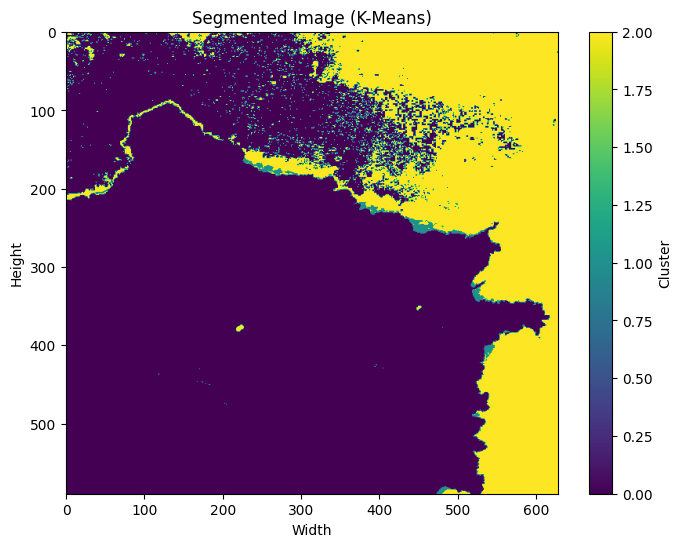

In [46]:
### visualize clusters

original_image = np.stack((
    nir_cropped,
    blue_cropped,
    red_cropped,
    green_cropped,
    coastal_cropped
), axis=2) 

segmented_image = labels.reshape(original_image.shape[:2])

# Plot the segmented image
plt.figure(figsize=(8, 6))
plt.imshow(segmented_image, cmap='viridis')  # You can choose any colormap you prefer
plt.colorbar(label='Cluster')
plt.title('Segmented Image (K-Means)')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

In [47]:
### calculate percentage of each cluster in each segment

mask_class0 = final_mask_Posidonia
mask_class1 = final_mask_water
mask_class2 = final_mask_Land

# Count unique values in segmented_image
unique_values = np.unique(segmented_image)

# Initialize a dictionary to store percentages
percentage_dict = {}

# Iterate over unique values
for value in unique_values:
    # Mask for pixels with the current value in segmented_image
    value_mask = segmented_image == value
    
    # Calculate percentages within each mask
    percentages = []
    for mask in [mask_class0, mask_class1, mask_class2]:
        # Count pixels within the current mask and with the current value
        pixels_in_mask = np.sum(np.logical_and(value_mask, mask))
        total_pixels = np.sum(mask)  # Total number of pixels in the mask
        percentage = (pixels_in_mask / total_pixels) * 100
        
        percentages.append(percentage)
    
    # Store percentages in the dictionary
    percentage_dict[value] = percentages

# Create a table to display the percentages
print("Unique Value\tPercentage in Mask 0\tPercentage in Mask 1\tPercentage in Mask 2")
for value, percentages in percentage_dict.items():
    print(f"{value}\t\t{percentages[0]:.2f}%\t\t\t{percentages[1]:.2f}%\t\t\t{percentages[2]:.2f}%")

Unique Value	Percentage in Mask 0	Percentage in Mask 1	Percentage in Mask 2
0		50.84%			37.85%			100.00%
1		5.97%			1.24%			0.00%
2		43.19%			60.91%			0.00%


In [48]:
### repeat with scaled values
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Perform K-means clustering with K=3
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)

# Get the labels of the clusters
labels = kmeans.labels_

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


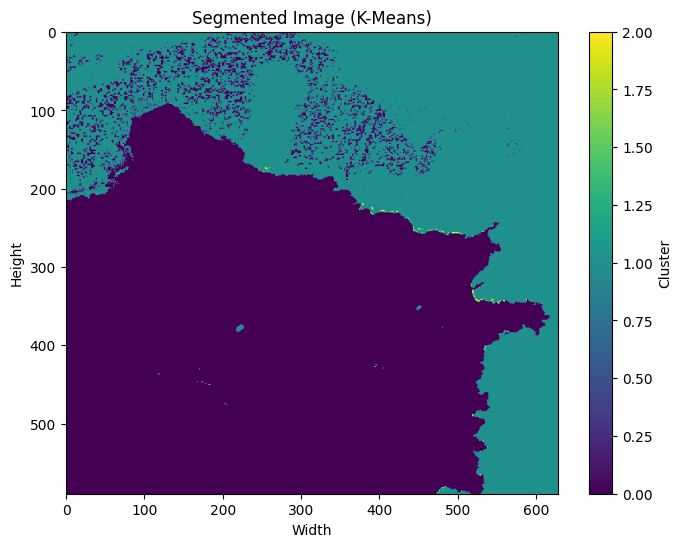

In [49]:
### visualize clusters

original_image = np.stack((
    nir_cropped,
    blue_cropped,
    red_cropped,
    green_cropped,
    coastal_cropped
), axis=2) 

segmented_image = labels.reshape(original_image.shape[:2])

# Plot the segmented image
plt.figure(figsize=(8, 6))
plt.imshow(segmented_image, cmap='viridis')  # You can choose any colormap you prefer
plt.colorbar(label='Cluster')
plt.title('Segmented Image (K-Means)')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

Using k-means clustering for segmenting a hyperspectral multiband satellite image into three classes has both advantages and limitations:

Advantages:

    Unsupervised Learning: K-means clustering is an unsupervised learning algorithm, meaning it does not require labeled data for training. In the context of satellite image segmentation, where obtaining labeled data may be time-consuming or costly, unsupervised methods like k-means can be advantageous.

    Simple and Fast: K-means clustering is computationally efficient and easy to implement. It scales well with large datasets, making it suitable for segmenting high-resolution satellite images with many bands.

    Applicable to Multiband Data: K-means clustering can handle multiband data, such as hyperspectral images, where each pixel contains information from multiple spectral bands. It clusters pixels based on their spectral similarity, allowing for the segmentation of complex and high-dimensional data.

Limitations:

    Assumes Equal-Sized and Spherical Clusters: K-means assumes that clusters are spherical and of equal size, which may not always hold true for real-world data. In the case of satellite imagery, where clusters can vary in shape, size, and density, this assumption may lead to suboptimal segmentation results.

    Sensitive to Initialization: K-means is sensitive to the initial placement of cluster centroids. Different initializations can lead to different clustering results, and there's no guarantee that the algorithm will converge to the global optimum.

    Difficulty in Determining Number of Clusters: K-means requires specifying the number of clusters (k) beforehand. In the context of satellite image segmentation, determining the optimal number of clusters can be challenging, especially if the data is complex or contains overlapping classes.

    Not Robust to Outliers: K-means is sensitive to outliers, which can significantly impact the clustering results. Outliers in satellite imagery, such as noise or artifacts, may introduce errors in the segmentation process.

    May Produce Uninterpretable Results: While k-means can effectively group pixels based on spectral similarity, the resulting clusters may not always correspond to meaningful objects or features in the image. Interpretation of the segmented classes may require additional domain knowledge or post-processing steps.

In summary, while k-means clustering offers a simple and efficient approach to segmenting hyperspectral multiband satellite images into classes, it comes with certain limitations related to its assumptions, sensitivity to initialization, and the challenge of determining the optimal number of clusters. It is essential to carefully consider these factors and potentially explore alternative segmentation methods based on the specific characteristics of the satellite imagery and the segmentation task at hand.

### Task 4

Task 4: Application in Predictive Analytics (10 Marks)
Choose one predictive analytics application (e.g., sales forecasting or customer churn prediction).
Build a machine learning model to address the chosen application.
Evaluate the model's performance and discuss the practical implications.

In [76]:
### downloaded data from: https://www.kaggle.com/datasets/blastchar/telco-customer-churn?select=WA_Fn-UseC_-Telco-Customer-Churn.csv

# Load the Telco Customer Churn dataset from an Excel file
churn_data = pd.read_csv('customer_churn.csv')
churn_data.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [61]:
churn_data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [65]:
print(churn_data.dtypes)

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


In [75]:
# Drop columns that are not useful for prediction or have high cardinality
churn_data = churn_data.drop(columns=['customerID'])

# Clean column names to remove any leading or trailing whitespaces
churn_data.columns = churn_data.columns.str.strip()

# Convert categorical variables to one-hot encoding, excluding the target variable 'Churn'
categorical_cols = churn_data.select_dtypes(include=['object']).drop(columns=['Churn']).columns
churn_data = pd.get_dummies(churn_data, columns=categorical_cols)

churn_data.columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'Churn', 'gender_Female',
       'gender_Male', 'Partner_No', 'Partner_Yes', 'Dependents_No',
       'Dependents_Yes',
       ...
       'TotalCharges_995.35', 'TotalCharges_996.45', 'TotalCharges_996.85',
       'TotalCharges_996.95', 'TotalCharges_997.65', 'TotalCharges_997.75',
       'TotalCharges_998.1', 'TotalCharges_999.45', 'TotalCharges_999.8',
       'TotalCharges_999.9'],
      dtype='object', length=6576)

In [77]:
### do the actual prediction

from sklearnex import patch_sklearn
patch_sklearn()
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

# Assuming churn_data is your pandas DataFrame
# Drop columns that are not useful for prediction or have high cardinality
churn_data = churn_data.drop(columns=['customerID'])

# Clean column names to remove any leading or trailing whitespaces
churn_data.columns = churn_data.columns.str.strip()

# Separate categorical and numerical columns
categorical_cols = churn_data.select_dtypes(include=['object']).columns
numerical_cols = churn_data.select_dtypes(exclude=['object']).columns

# Convert categorical variables to numerical using label encoding
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    churn_data[col] = label_encoders[col].fit_transform(churn_data[col])

# Split the dataset into features (X) and target variable (y)
X = churn_data.drop(columns=['Churn'])  # Features
y = churn_data['Churn']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBoost model
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

num_boost_round = 100
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

bst = xgb.train(params, dtrain, num_boost_round=num_boost_round)

# Make predictions on the test set
y_pred_prob = bst.predict(dtest)
y_pred = np.round(y_pred_prob)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Evaluation Metrics:
Accuracy: 0.8126330731014905
Precision: 0.6860068259385665
Recall: 0.5388739946380697
F1-score: 0.6036036036036037


Using XGBoost to predict churn has various practical applications in industries where customer retention is crucial, such as telecommunications, subscription-based services, banking, e-commerce, and more. Here are some practical applications:

    Telecommunications: Telecom companies can predict customer churn to identify at-risk customers and take proactive measures to retain them, such as offering personalized discounts, upgrading service plans, or providing better customer service.

    Subscription-Based Services: Businesses offering subscription services like streaming platforms, software-as-a-service (SaaS), or membership-based platforms can use churn prediction to understand customer behavior, optimize subscription plans, and implement targeted retention strategies.

    Banking and Financial Services: Banks and financial institutions can predict customer churn to prevent account closures, reduce customer attrition, and enhance customer satisfaction by offering tailored financial products, personalized recommendations, and improved customer service.

    E-commerce: E-commerce companies can use churn prediction to reduce customer churn, increase customer lifetime value, and improve customer engagement by sending personalized offers, loyalty rewards, and targeted marketing campaigns based on individual customer preferences and behavior.

    Healthcare: Healthcare providers can predict patient churn to enhance patient retention, improve patient outcomes, and optimize resource allocation by identifying patients at risk of discontinuing medical treatments or switching healthcare providers.

    Retail: Retail businesses can leverage churn prediction to reduce customer churn, increase customer loyalty, and drive revenue growth by implementing personalized marketing strategies, improving customer experience, and offering incentives to retain customers.

In summary, XGBoost churn prediction models can help businesses across various industries to proactively identify customers at risk of churn, tailor retention strategies, and ultimately improve customer retention, satisfaction, and profitability.